In [1]:
import sys
import logging

from my_minimal_example import main
%load_ext autoreload
%autoreload 2

# Redirects logs directly into the jupyter notebook
import logging, sys
logging.basicConfig(level=logging.INFO, handlers=[logging.StreamHandler(sys.stdout)], format='%(message)s')
logger = logging.getLogger()

/volatile/home/pj273170/anaconda3/envs/breaching/lib/python3.9/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11070). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [30]:
import torch
x = [torch.randn(25,10) for _ in range(10)]
x_reduced = torch.mean(torch.stack(x), dim=0)
print(x_reduced.shape)

torch.Size([25, 10])


In [29]:
import torch

feats_rec = torch.randn(25, 10)
feats_true = torch.randn(25, 10)
relevant_features = torch.randint(0, 10, (25,))
print(relevant_features.shape)
before_feat_mse = (feats_rec - feats_true)
feat_mse = (feats_rec - feats_true)[..., relevant_features.view(-1)]
print(before_feat_mse.shape)
print(feat_mse.shape)

torch.Size([25])
torch.Size([25, 10])
torch.Size([25, 25])


In [40]:
from breaching.cases.models import custom_models
from torchsummary import summary

layer_name = [
    "conv",
    "batchnorm",
    "relu",
    "maxpool",
    "avgpool",
    "dropout",
    "linear",
    "flatten",
    "identity",
    "sequential",
    "residual",
    "residual_block",
    "residual_bottleneck",
    "residual_bottleneck_block",
    
]

for name in dir(custom_models):
    if 'cifar10' in name:
        print(name)
        model_cls = getattr(custom_models, name)
        model = model_cls()
        print(summary(model, (3, 32, 32)))

    

cifar10_densenet121
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
       BatchNorm2d-5           [-1, 64, 16, 16]             128
              ReLU-6           [-1, 64, 16, 16]               0
            Conv2d-7          [-1, 128, 16, 16]           8,192
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
           Conv2d-10           [-1, 32, 16, 16]          36,864
      BatchNorm2d-11           [-1, 96, 16, 16]             192
             ReLU-12           [-1, 96, 16, 16]               0
           Conv2d-13          [-1, 128, 16, 16]          12,288
      BatchNorm2d-1

In [17]:
getattr(torchvision.transforms, "Resize")((32, 32))

Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=warn)

In [25]:
list("(32,32)")

['(', '3', '2', ',', '3', '2', ')']

In [38]:
import torch
import numpy as np
from omegaconf import OmegaConf
import torchvision
import breaching
# cfg = OmegaConf.load("/volatile/home/pj273170/Code/Breaching/breaching/breaching/config/Adam_cfg.yaml")
def resolve_tuple(*args):
    return tuple(args)

# OmegaConf.register_new_resolver('as_tuple', resolve_tuple)
cfg = breaching.get_config(config_name="Adam_cfg", overrides=["case/data=MNIST"])
OmegaConf.resolve(cfg)

cfg_data = cfg.case.data
split = True
# print(OmegaConf.to_yaml(cfg_data))
from breaching.cases.data import datasets_vision
def _parse_cfg_dict(cfg_dict):
    list_of_transforms = []
    if hasattr(cfg_dict, "keys"):
        for key in cfg_dict.keys():
            if isinstance(cfg_dict[key], str):
                str_key = cfg_dict[key].replace(" ", "")
                transform = getattr(torchvision.transforms, key)(tuple(map(int, str_key.split(','))))
            else:
                try:  # ducktype iterable
                    print(key)
                    print(cfg_dict[key])
                    print(type(cfg_dict[key]))
                    transform = getattr(torchvision.transforms, key)(*cfg_dict[key])
                except TypeError:
                    transform = getattr(torchvision.transforms, key)(cfg_dict[key])
            list_of_transforms.append(transform)
    return list_of_transforms

_parse_cfg_dict(cfg_data.augmentations_train)


OverrideParseException: mismatched input '=' expecting <EOF>
See https://hydra.cc/docs/1.2/advanced/override_grammar/basic for details

In [2]:
import lpips

lpips.LPIPS(net="alex", verbose=False)

/volatile/home/pj273170/anaconda3/envs/breaching/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/volatile/home/pj273170/anaconda3/envs/breaching/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


LPIPS(
  (scaling_layer): ScalingLayer()
  (net): alexnet(
    (slice1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
    )
    (slice2): Sequential(
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
    )
    (slice3): Sequential(
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
    )
    (slice4): Sequential(
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
    )
    (slice5): Sequential(
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
    )
  )
  (lin0): NetLinLayer(
    (model): Sequential(
      (0): D

In [3]:
from omegaconf import OmegaConf, open_dict
from breaching import get_config
import breaching
import sys

sys.path.append("/volatile/home/pj273170/Code/PyTorch_CIFAR10")
from cifar10_models.mobilenetv2 import mobilenet_v2 as cifar10_mobilenet_v2

cfg = get_config(config_name="Adam_cfg")
# print(OmegaConf.to_yaml(cfg))
with open_dict(cfg):
    cfg.case.model = "cifar10_mobilenet_v2"

model, loss_fn = breaching.cases.construct_model(cfg.case.model, cfg.case.data, True)
print(model.model.features[0][0].weight[0][0])

model, loss_fn = breaching.cases.construct_model(cfg.case.model, cfg.case.data, False)
print(model.model.features[0][0].weight[0][0])

model = cifar10_mobilenet_v2(pretrained=True)
print(model.features[0][0].weight[0][0])

Investigating use case image_custom with server type honest_but_curious.
B
tensor([[-0.0026,  0.0041, -0.0072],
        [-0.0120,  0.0374,  0.0268],
        [-0.0177,  0.0280,  0.0304]], grad_fn=<SelectBackward0>)
B
tensor([[-0.1113, -0.0487,  0.0280],
        [ 0.0581, -0.0264, -0.1308],
        [ 0.0426, -0.0163,  0.0539]], grad_fn=<SelectBackward0>)
tensor([[-0.0026,  0.0041, -0.0072],
        [-0.0120,  0.0374,  0.0268],
        [-0.0177,  0.0280,  0.0304]], grad_fn=<SelectBackward0>)


In [72]:
attacker, reconstructed_user_data, stats = main()

Loading attack configuration optimization-deep-leakage.
Attacker (of type OptimizationBasedAttacker) with settings:
    Hyperparameter Template: deep-leakage

    Objective: Euclidean loss with scale=1.0 and task reg=0.0
    Regularizers: 
    Augmentations: 

    Optimization Setup:
        optimizer: adam
        signed: None
        step_size: 0.1
        boxed: False
        max_iterations: 2400
        step_size_decay: None
        langevin_noise: 0.0
        warmup: 0
        grad_clip: None
        callback: 100
        
INFO:breaching.attacks.optimization_based_attack:| It: 1/2400 | Rec. loss: 12.3612 |  Task loss: 2.2611 | T: 0.02s
INFO:breaching.attacks.optimization_based_attack:| It: 101/2400 | Rec. loss: 0.1888 |  Task loss: 2.2973 | T: 2.40s
INFO:breaching.attacks.optimization_based_attack:| It: 201/2400 | Rec. loss: 0.1662 |  Task loss: 2.2982 | T: 2.30s
INFO:breaching.attacks.optimization_based_attack:| It: 301/2400 | Rec. loss: 0.1551 |  Task loss: 2.2987 | T: 2.20s
INF

[tensor(3), tensor(8), tensor(8), tensor(0)]


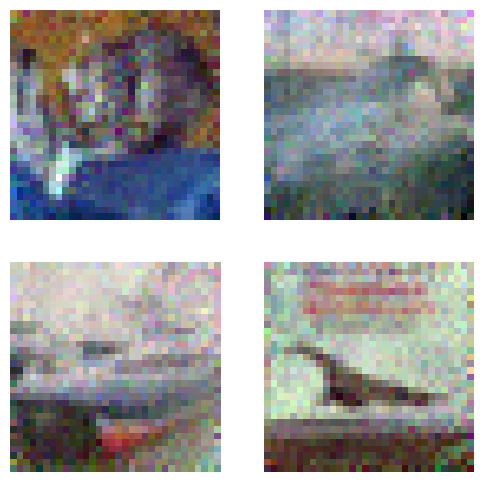

In [71]:
import torch

from my_minimal_example import data_cfg_default
import matplotlib.pyplot as plt
print_labels = True
scale = True
data, labels = reconstructed_user_data["data"], reconstructed_user_data["labels"]

dm = attacker.dm
ds = attacker.ds

if scale:
    min_val, max_val = data.amin(dim=[2, 3], keepdim=True), data.amax(dim=[2, 3], keepdim=True)
    # print(f'min_val: {min_val} | max_val: {max_val}')
    data = (data - min_val) / (max_val - min_val)
else:
    data.mul_(ds).add_(dm).clamp_(0, 1)
data = data.to(dtype=torch.float32)

grid_shape = int(torch.as_tensor(data.shape[0]).sqrt().ceil())
s = 24 if data.shape[3] > 150 else 6
fig, axes = plt.subplots(grid_shape, grid_shape, figsize=(s, s))
label_classes = []
for i, (im, axis) in enumerate(zip(data, axes.flatten())):
    axis.imshow(im.permute(1, 2, 0).cpu())
    if labels is not None and print_labels:
        label_classes.append(labels[i])
    axis.axis("off")
if print_labels:
    print(label_classes)